
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries under a climate change scenario (future TCs occurrence probability)

inputs required: 
  * Historical DWTs (for plotting)
  * Historical wave families (for plotting)
  * Synthetic DWTs climate change
  * Historical intradaily hydrograph parameters  
  * TCs waves
  
in this notebook:
  * Generate synthetic time series of wave conditions   
  * Validate the synthetic waves by means of mean distributions
  * 
  <span style='color:Red'> TODO: ¿¿Compare the synthetic waves by means of mean distributions **(with and without climate change)**??. ¿¿ QUEDAN IGUALES PRACTICAMETNE ?? </span>


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import shutil


# pip
import numpy as np
import xarray as xr
np.set_printoptions(precision=3)
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.climate_change import Plot_RCP_ocurrence



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S5
db_S5 = Database(p_data)
db_S5.SetSite('ROI_CC_S5')


# climate emulator simulation modified path
p_S5_CE_sims = op.join(db_S5.paths.site.EXTREMES.climate_emulator, 'Simulations')


In [3]:
# --------------------------------------
# Load data for plotting (waves partitions and families, KMA, DWT)

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)


# --------------------------------------
# Load data for climate emulator simulation climate change: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db_S5.Load_ESTELA_DWT_sim() # DWTs climate change

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

TCs_probs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
TCs_pchange = TCs_probs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each DWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])



In [4]:
# TODO developer
DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))



## Climate Emulator - Simulation

In [5]:
# --------------------------------------
# Climate Emulator extremes model fitting

# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

# set a new path for S5 simulations
CE.Set_Simulation_Folder(p_S5_CE_sims, copy_WAVES_noTCs = False)  # climate change waves (no TCs) not simulated, DWTs have changed

# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)
    
    # Simulate waves
    n_ce = 1  # (one CE sim. for each DWT sim.)
    WVS_sim = CE.Simulate_Waves(DWTs, n_ce, filters={'hs':True, 'tp':True, 'ws':True})

    # Simulate TCs and update simulated waves
    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, TCs_pchange, MU_WT, TAU_WT)
    
    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))
    

- Sim: 1 -


C.E: Sim. TCs  : 100%|██████████| 113875/113875 [00:03<00:00, 28501.98it/s]


- Sim: 2 -


C.E: Sim. TCs  : 100%|██████████| 113970/113970 [00:03<00:00, 29558.06it/s]


- Sim: 3 -


C.E: Sim. TCs  : 100%|██████████| 113764/113764 [00:03<00:00, 28547.28it/s]


- Sim: 4 -


C.E: Sim. TCs  : 100%|██████████| 114351/114351 [00:04<00:00, 28536.86it/s]


- Sim: 5 -


C.E: Sim. TCs  : 100%|██████████| 113676/113676 [00:03<00:00, 28475.10it/s]


- Sim: 6 -


C.E: Sim. TCs  : 100%|██████████| 114004/114004 [00:04<00:00, 28375.55it/s]


- Sim: 7 -


C.E: Sim. TCs  : 100%|██████████| 114335/114335 [00:04<00:00, 28179.95it/s]


- Sim: 8 -


C.E: Sim. TCs  : 100%|██████████| 114339/114339 [00:04<00:00, 28351.94it/s]


- Sim: 9 -


C.E: Sim. TCs  : 100%|██████████| 114142/114142 [00:04<00:00, 28045.28it/s]


- Sim: 10 -


C.E: Sim. TCs  : 100%|██████████| 114136/114136 [00:04<00:00, 27861.38it/s]


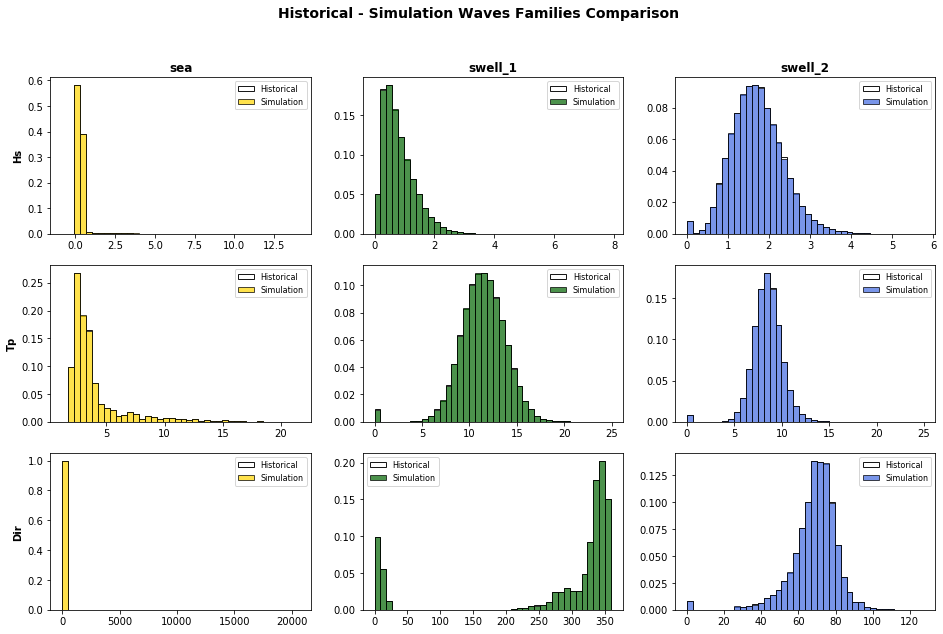

(array([  26684,   42213,   45437,  185198,  233242,  351560,  378676,
        411421,  417047,  476750,  479158,  565045,  590894,  647319,
        698844,  732084,  748873,  841648,  923111,  931296,  984020,
       1049392, 1054589, 1057451, 1072409, 1074241]),)
(array([  31621,  106246,  133810,  178998,  231618,  373368,  410387,
        428157,  428444,  467189,  471912,  491211,  552450,  582826,
        669410,  786048,  806258,  811092,  832651,  840420,  867409,
        899653,  977567, 1013137, 1019853, 1022112, 1049568]),)


SystemExit: 

In [3]:
# --------------------------------------
# Plot all Simulations 
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)


# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

WVS_upd_all_sims = CE.LoadSim_All(n_sim_ce = n_sim_CE)
WVS_upd_all_sims = WVS_upd_all_sims.to_xarray()


# Load Climate Emulator climate change
CE.Set_Simulation_Folder(p_S5_CE_sims)

WVS_upd_all_sims_CC = CE.LoadSim_All(n_sim_ce = n_sim_CE)
WVS_upd_all_sims_CC = WVS_upd_all_sims_CC.to_xarray()


# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_upd_all_sims, WVS_upd_all_sims_CC);


# TODO: en las simulaciones (con y sin cambio climatico), sea_DIR da direcciones >360

# TODO: change legend
    # historical --> simulation
    # simulation --> simulation climate change

# TODO: no hay apenas diferencias... como lo pintamos?

# TODO: aplicar este cambio al resto de escenarios

print(np.where(WVS_upd_all_sims.sea_Dir.values>360))
print(np.where(WVS_upd_all_sims_CC.sea_Dir.values>360))

